# **Model Evaluation**

This notebook loads the saved model (`model_2_v2.h5`) and performs evaluation including:
- Model loading and summary
- Model accuracy and classification metrics
- Detailed classification report
- Confusion matrix visualization
- Summary statistics


In [1]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score,
    cohen_kappa_score
)
import pandas as pd

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")


### **Configuration**

Set up paths and parameters.


In [2]:
# Configuration
MODEL_PATH = 'model_2_v2.h5'
DATASET_DIR = "plantvillage dataset/color"
IMG_SIZE = 224
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


### **Load Model**

Load the pre-trained model from the H5 file.


In [3]:
# Load the saved model
print(f"Loading model from {MODEL_PATH}...")
model = load_model(MODEL_PATH)
print("Model loaded successfully!")
print(f"\nModel Summary:")
model.summary()


Loading model from model_2_v2.h5...


Model loaded successfully!

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,384 (1.71 MB)

 Trainable params: 448,678 (1.71 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

### **Prepare Data**

Set up data generators for validation set.


In [4]:
# Create data generator for validation (no augmentation, just rescaling)
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Validation generator
validation_generator = data_gen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False  # Important: don't shuffle for consistent evaluation
)

# Get class names and indices
class_names = list(validation_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Validation samples: {validation_generator.samples}")
print(f"\nClass names (first 10): {class_names[:10]}")


Found 10849 images belonging to 38 classes.
Number of classes: 38
Validation samples: 10849

Class names (first 10): ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


### **Model Accuracy**

Evaluate the model on the validation set.


In [5]:
# Calculate steps for evaluation
steps = int(np.ceil(validation_generator.samples / BATCH_SIZE))

# Evaluate the model
print("Evaluating model on validation set...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=steps, verbose=1)

print(f"\n{'='*50}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"{'='*50}")


Evaluating model on validation set...


c:\ProgramData\miniconda3\envs\jupyter-global\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


679/679 ━━━━━━━━━━━━━━━━━━━━ 118s 172ms/step - accuracy: 0.9280 - loss: 0.2099

Validation Loss: 0.2099
Validation Accuracy: 92.80%


### **Generate Predictions**

Make predictions on the validation set.


In [6]:
# Generate predictions
print("Generating predictions on validation set...")
y_pred_proba = model.predict(validation_generator, steps=steps, verbose=1)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = validation_generator.classes

print(f"Predictions shape: {y_pred_proba.shape}")
print(f"True labels shape: {y_true.shape}")
print(f"Predicted labels shape: {y_pred.shape}")


Generating predictions on validation set...
679/679 ━━━━━━━━━━━━━━━━━━━━ 112s 164ms/step
Predictions shape: (10849, 38)
True labels shape: (10849,)
Predicted labels shape: (10849,)


### **Classification Metrics**

Calculate overall classification metrics.


In [7]:
# Calculate overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
kappa_score = cohen_kappa_score(y_true, y_pred)

print("="*60)
print("OVERALL CLASSIFICATION METRICS")
print("="*60)
print(f"Accuracy:        {overall_accuracy * 100:.2f}%")
print(f"Precision:       {overall_precision * 100:.2f}%")
print(f"Recall:          {overall_recall * 100:.2f}%")
print(f"F1-Score:        {overall_f1 * 100:.2f}%")
print(f"Cohen's Kappa:   {kappa_score:.4f}")
print("="*60)


OVERALL CLASSIFICATION METRICS
Accuracy:        92.80%
Precision:       93.32%
Recall:          92.80%
F1-Score:        92.77%
Cohen's Kappa:   0.9245


### **Detailed Classification Report**

Generate a comprehensive classification report with per-class metrics.


In [8]:
# Generate detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60 + "\n")
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    zero_division=0
)
print(report)



DETAILED CLASSIFICATION REPORT

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.83      0.91      0.87       126
                                 Apple___Black_rot       0.72      0.96      0.82       124
                          Apple___Cedar_apple_rust       0.74      0.64      0.69        55
                                   Apple___healthy       0.98      0.85      0.91       329
                               Blueberry___healthy       0.91      1.00      0.95       300
          Cherry_(including_sour)___Powdery_mildew       0.89      0.88      0.89       210
                 Cherry_(including_sour)___healthy       0.67      0.99      0.80       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.87      0.74      0.80       102
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
               Corn_(maize)___Northern_Leaf_Bl

### **Confusion Matrix**

Visualize the confusion matrix with a green color scheme optimized for 38 classes.


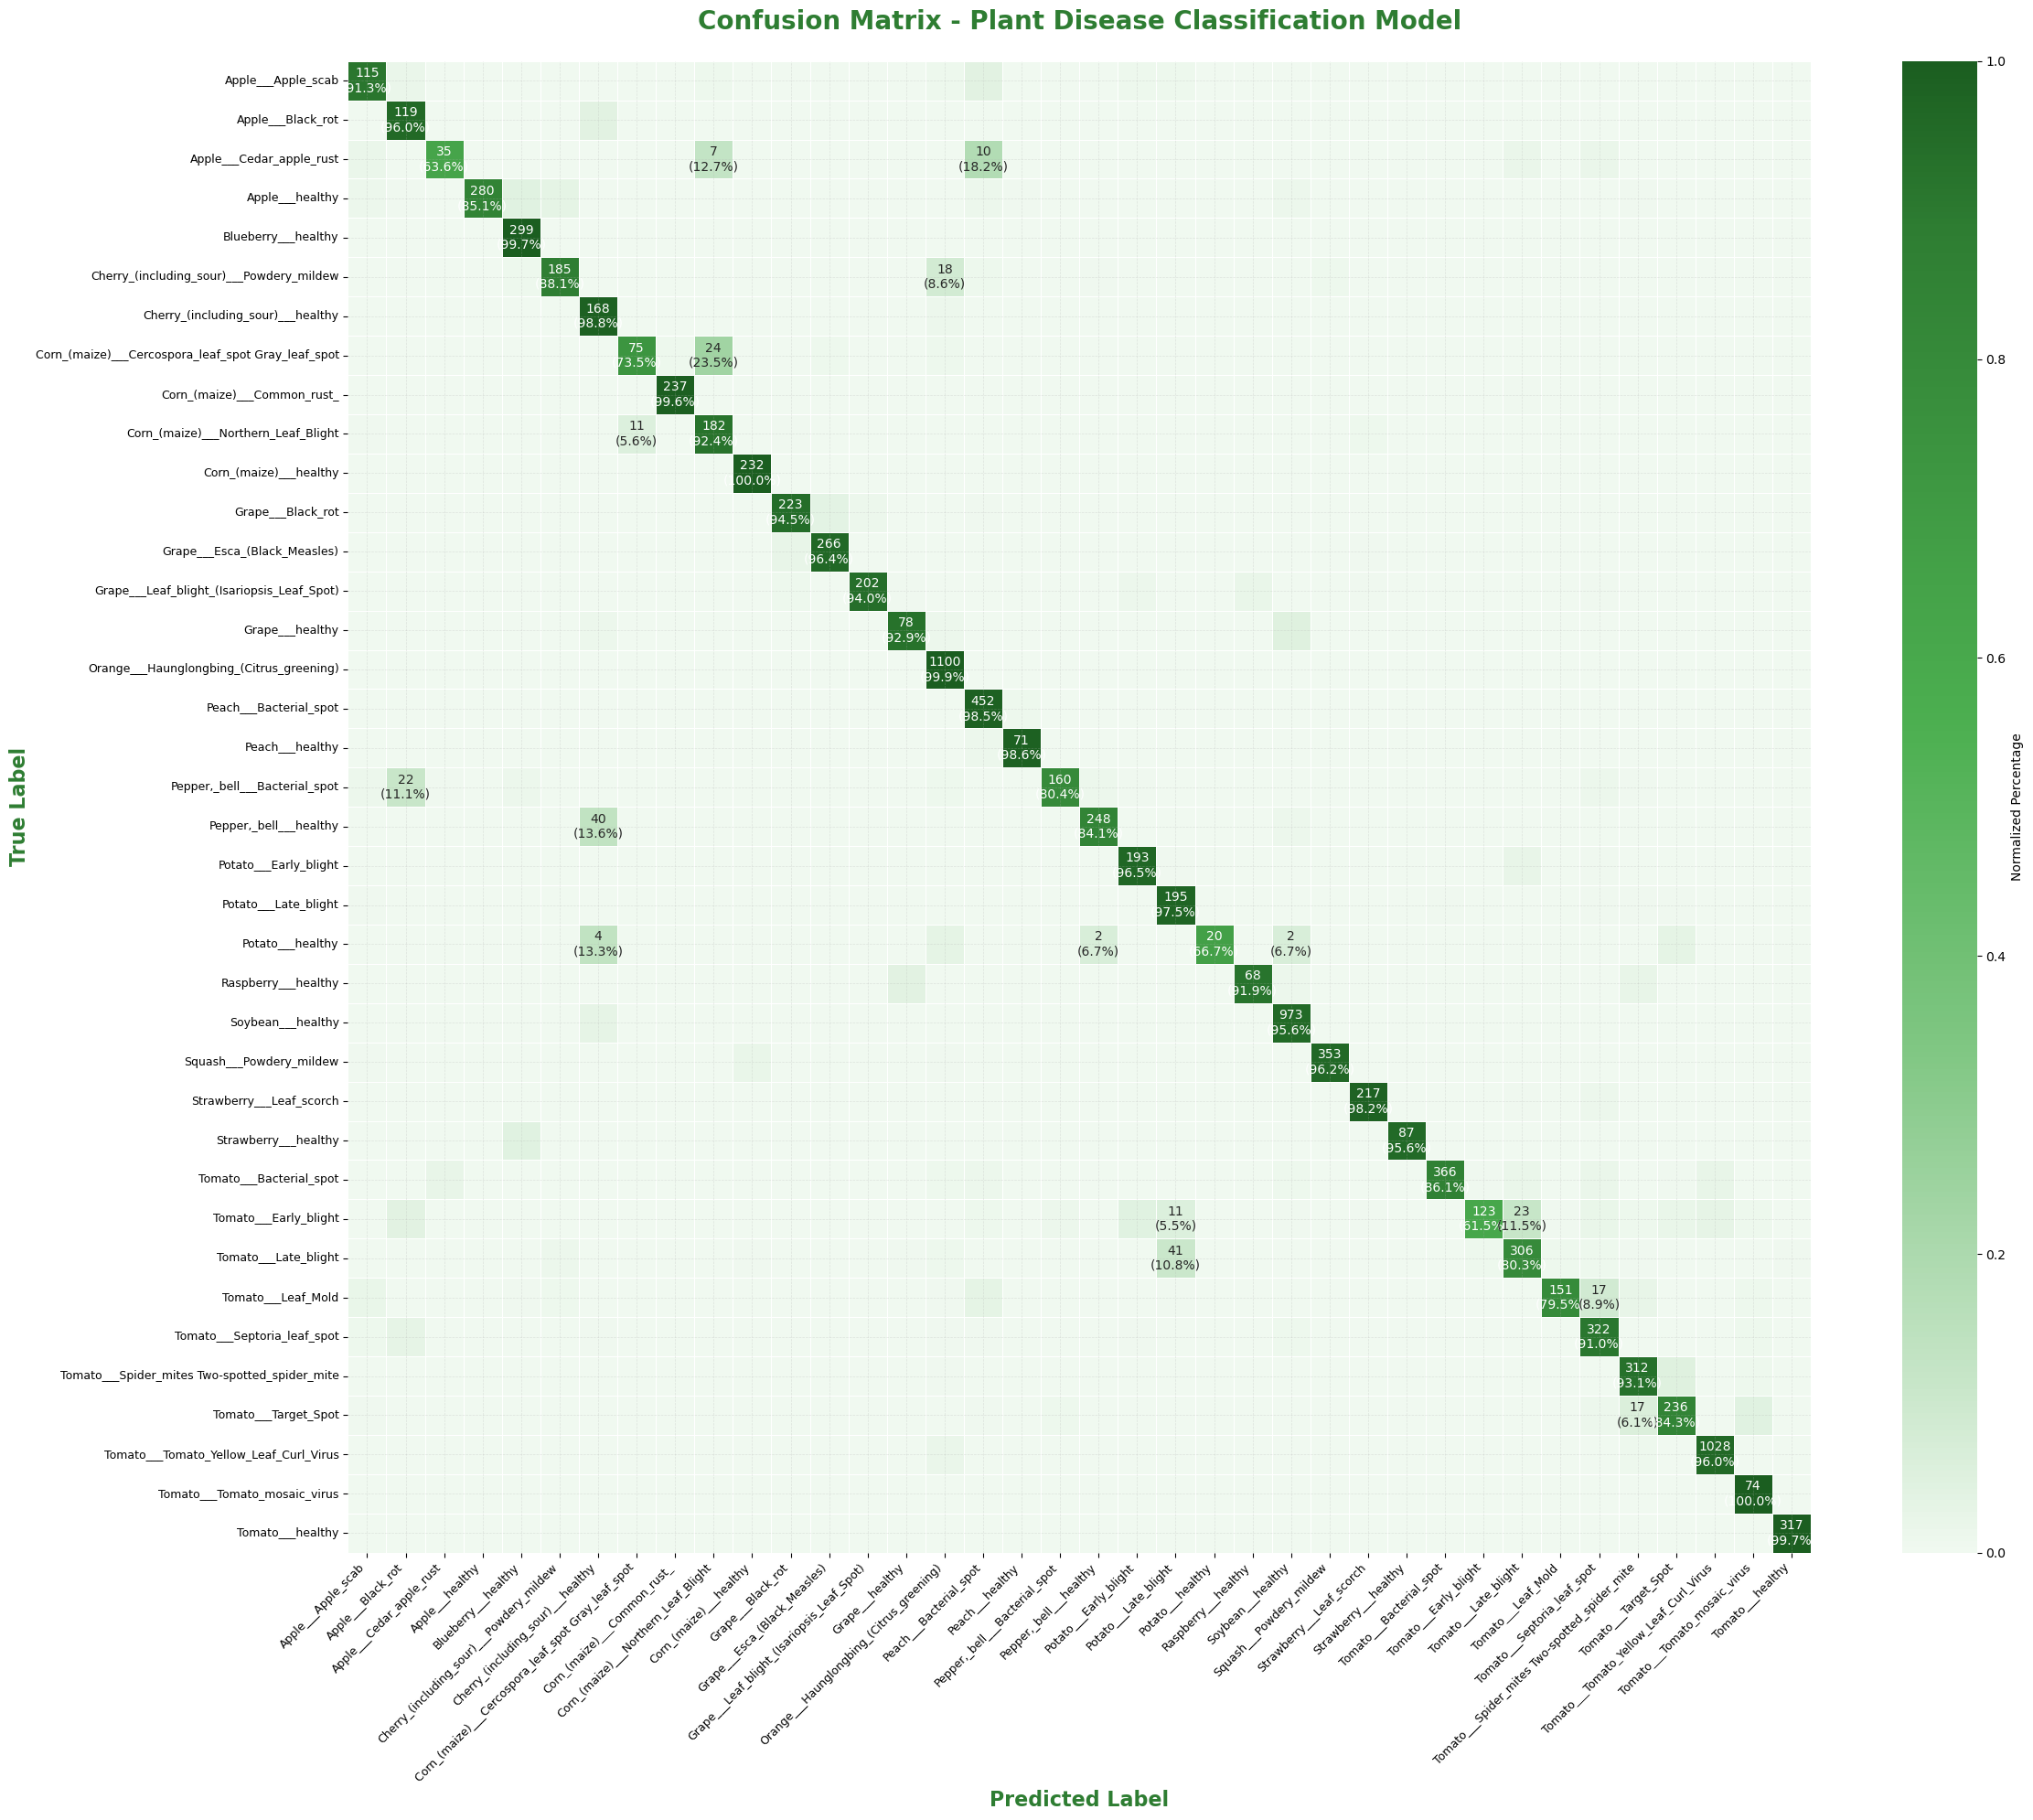


CONFUSION MATRIX STATISTICS
Total predictions:     10849
Correct predictions:   10068 (92.80%)
Incorrect predictions: 781 (7.20%)


In [9]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize for better visualization (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Handle any NaN values

# Create a large figure optimized for 38 classes
fig, ax = plt.subplots(figsize=(24, 20))

# Use green color scheme - Create custom green colormap (light to dark green)
from matplotlib.colors import LinearSegmentedColormap
colors = ['#f0f9f0', '#c8e6c9', '#a5d6a7', '#81c784', '#66bb6a', '#4caf50', '#43a047', '#388e3c', '#2e7d32', '#1b5e20']
n_bins = 256
green_cmap = LinearSegmentedColormap.from_list('plant_green', colors, N=n_bins)

# Create annotation matrix - only show diagonal and significant confusions to reduce clutter
annot_matrix = np.zeros_like(cm_normalized, dtype=object)
for i in range(len(cm_normalized)):
    for j in range(len(cm_normalized)):
        if i == j:  # Always show diagonal
            annot_matrix[i, j] = f'{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)'
        elif cm_normalized[i, j] > 0.05:  # Only show if > 5% confusion
            annot_matrix[i, j] = f'{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)'
        else:
            annot_matrix[i, j] = ''

# Plot heatmap
sns.heatmap(
    cm_normalized,
    annot=annot_matrix,
    fmt='',
    cmap=green_cmap,
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Normalized Percentage'},
    linewidths=0.5,
    linecolor='white',
    square=False,
    vmin=0,
    vmax=1,
    ax=ax
)

# Customize labels and title
ax.set_title('Confusion Matrix - Plant Disease Classification Model', 
             fontsize=20, fontweight='bold', pad=25, color='#2e7d32')
ax.set_ylabel('True Label', fontsize=16, fontweight='bold', color='#2e7d32')
ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold', color='#2e7d32')

# Rotate labels for better readability
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(class_names, rotation=0, fontsize=9)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"CONFUSION MATRIX STATISTICS")
print(f"{'='*60}")
print(f"Total predictions:     {cm.sum()}")
print(f"Correct predictions:   {np.trace(cm)} ({np.trace(cm)/cm.sum()*100:.2f}%)")
print(f"Incorrect predictions: {cm.sum() - np.trace(cm)} ({(cm.sum() - np.trace(cm))/cm.sum()*100:.2f}%)")
print(f"{'='*60}")


### **Summary Statistics**

Generate a comprehensive summary of all evaluation metrics.


               EVALUATION SUMMARY
               Metric           Value
     Overall Accuracy          92.80%
   Weighted Precision          93.32%
      Weighted Recall          92.80%
    Weighted F1-Score          92.77%
        Cohen's Kappa          0.9245
      Validation Loss          0.2099
        Total Samples          10,849
  Correct Predictions 10,068 (92.80%)
Incorrect Predictions     781 (7.20%)


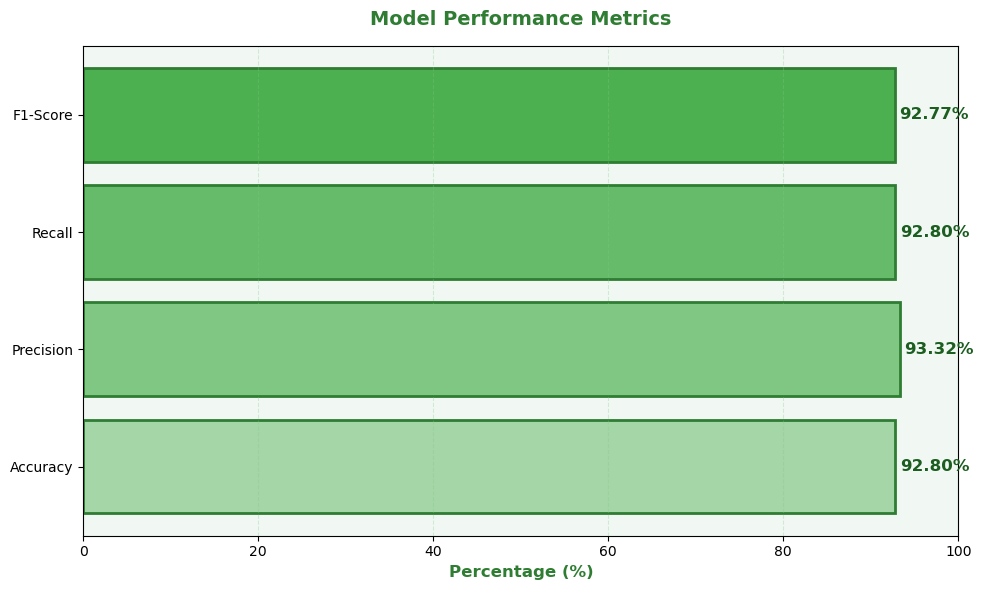

In [10]:
# Create summary statistics
summary_stats = {
    'Metric': [
        'Overall Accuracy',
        'Weighted Precision',
        'Weighted Recall',
        'Weighted F1-Score',
        "Cohen's Kappa",
        'Validation Loss',
        'Total Samples',
        'Correct Predictions',
        'Incorrect Predictions'
    ],
    'Value': [
        f"{overall_accuracy * 100:.2f}%",
        f"{overall_precision * 100:.2f}%",
        f"{overall_recall * 100:.2f}%",
        f"{overall_f1 * 100:.2f}%",
        f"{kappa_score:.4f}",
        f"{val_loss:.4f}",
        f"{len(y_true):,}",
        f"{np.sum(y_pred == y_true):,} ({np.sum(y_pred == y_true)/len(y_true)*100:.2f}%)",
        f"{np.sum(y_pred != y_true):,} ({np.sum(y_pred != y_true)/len(y_true)*100:.2f}%)"
    ]
}

summary_df = pd.DataFrame(summary_stats)

# Display summary with green-themed styling
print("="*70)
print(" " * 15 + "EVALUATION SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Create a visual summary
fig, ax = plt.subplots(figsize=(10, 6))
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [
    overall_accuracy * 100,
    overall_precision * 100,
    overall_recall * 100,
    overall_f1 * 100
]

# Use green color gradient
colors_green = ['#a5d6a7', '#81c784', '#66bb6a', '#4caf50']
bars = ax.barh(metrics_names, metrics_values, color=colors_green, edgecolor='#2e7d32', linewidth=2)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    ax.text(val + 0.5, i, f'{val:.2f}%', 
            va='center', fontsize=12, fontweight='bold', color='#1b5e20')

ax.set_xlabel('Percentage (%)', fontsize=12, fontweight='bold', color='#2e7d32')
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold', color='#2e7d32', pad=15)
ax.set_xlim([0, 100])
ax.grid(axis='x', alpha=0.3, linestyle='--', color='#81c784')
ax.set_facecolor('#f1f8f4')

plt.tight_layout()
plt.show()
